# Optical cycling of TlF for rotational cooling
## Intro
This notebook goes through a calculation to determine the maximum optical cycling rate for the $X \rightarrow B(J = 1 \rightarrow J' = 1)$ transition used for rotational cooling of TlF molecules.

To start off, I present the energy level structure of the relevant system. The maximum cycling rates in the presence and absence of microwaves are then calculated. The goal with the microwaves is to cause an  AC Stark shift between the bright and the dark states of the system so that the optical dark states evolve into optical bright states quicker.

## Level structure
I'm simulating the full TlF level structure, so we have $I_1 = \frac{1}{2}$ and $I_2 = \frac{1}{2}$. The rotational levels that are considered here are J = 0 and 1 and J' = 1. The aim for this part is to simply produce a level diagram of the TlF relevant energy levels.

First import the Hamiltonian and find the correct energy levels.

In [9]:
#Import packages
import numpy as np
import sympy
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from classes import UncoupledBasisState, CoupledBasisState, State
%matplotlib notebook
%load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Import Hamiltonian
with open("hamiltonians_symbolic.py", 'rb') as f:
    hamiltonians = pickle.load(f)
with open("Hff_alt_mat.py", 'rb') as f:
    Hff_alt_mat_m = pickle.load(f)["Hff_alt_mat"]

    
Jmax = sympy.Integer(6) # max J value in Hamiltonian
I_Tl = 1/2             # I1 in Ramsey's notation/
I_F  = 1/2             # I2 in Ramsey's notation

def ni_range(x0, x1, dx=1):
    # sanity check arguments
    if dx==0:
        raise ValueError("invalid parameters: dx==0")
    if x0>x1 and dx>=0:
        raise ValueError("invalid parameters: x0>x1 and dx>=0")
    if x0<x1 and dx<=0:
        raise ValueError("invalid parameters: x0<x1 and dx<=0")
        
    # generate range list
    range_list = []
    x = x0
    while x < x1:
        range_list.append(sympy.Number(x))
        x += dx
    return range_list

#Make list of states so that can find states in the Hamiltonian
QN = [UncoupledBasisState(J,mJ,I_Tl,m1,I_F,m2)
      for J  in ni_range(0, Jmax+1)
      for mJ in ni_range(-J,J+1)
      for m1 in ni_range(-I_Tl,I_Tl+1)
      for m2 in ni_range(-I_F,I_F+1)
     ]

Convert the `sympy` `Matrix` into a `numpy` array:

In [3]:
%%time
variables = [
    sympy.symbols('Brot'),
    *sympy.symbols('c1 c2 c3 c4'),
    sympy.symbols('D_TlF'),
    *sympy.symbols('mu_J mu_Tl mu_F')
]

lambdified_hamiltonians = {
    H_name : sympy.lambdify(variables, H_matrix)
    for H_name, H_matrix in hamiltonians.items()
}

Wall time: 6.64 s


Insert numerical constants into Hamiltonian (all in units of Hz):

In [4]:
%%time
Brot = 6689920000
c1 = 126030.0
c2 = 17890.0
c3 = 700.0
c4 = -13300.0
D_TlF = 4.2282 * 0.393430307 *5.291772e-9/4.135667e-15 # [Hz/(V/cm)]
mu_J = 35
mu_Tl = 1240.5
mu_F = 2003.63

H = {
    H_name : H_fn(
        Brot,
        c1, c2, c3, c4,
        D_TlF,
        mu_J, mu_Tl, mu_F
    )
    for H_name, H_fn in lambdified_hamiltonians.items()
}

Wall time: 23.1 ms


### Find the energies

Above, we have evaluated the matrix elements for the zero-field Hamiltonian $H_\text{ff}$, as well as the $\vec E=1=\vec B$ cases. For general fields $\vec E,\vec B$, the Hamiltonian is

$$
H=H_\text{ff}
+
\begin{pmatrix}
E_x\\E_y\\E_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{S}_x\\H^\text{S}_y\\H^\text{S}_z
\end{pmatrix}
+
\begin{pmatrix}
B_x\\B_y\\B_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{Z}_x\\H^\text{Z}_y\\H^\text{Z}_z
\end{pmatrix}.
$$

When looking at the Zeeman/Stark effects on the hyperfine structure, the rotational structure is not of interest, so I subtract it for clarity in the following `spectrum()` function. It evaluates the above Hamiltonian for each point on the array of fields, and returns a list of energy levels, sorted by size:

In [38]:
def spectrum(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
    energies_arr = []
    energies_rot_arr = []
    states_arr = []
    for Ex,Ey,Ez,Bx,By,Bz in zip(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
        HamE = H["Hff"] + \
            Ex*H["HSx"]  + Ey*H["HSy"] + Ez*H["HSz"] + \
            Bx*H["HZx"]  + By*H["HZy"] + Bz*H["HZz"]
        D, V = np.linalg.eigh(HamE)
        idx = D.argsort() 
        D = D[idx]
        V = V[:,idx]
        
        # Subtract away rotational energy for easier viewing of substructure
        hfs_mat = []
        for i,state in enumerate(QN):
            J = state.J
            hfs_mat.append(D[i] - J*(J +1)*Brot)
        hfs_kHz = np.array(hfs_mat)/1000

        energies_arr.append(hfs_kHz)
        energies_rot_arr.append(D)
        states_arr.append(V)
    return np.array(energies_arr), np.array(energies_rot_arr), np.array(states_arr)

Calculate energies at zero field:

In [65]:
#Set values for electric and magnetic field
Ez = np.zeros(1)
Bz = np.zeros(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

#Calculate energies
energies,energies_rot, e_states = spectrum(Ex,Ey,Ez,Bx,By,Bz)


Make energy level diagram:

In [147]:
#Define which states we want to plot:
ground_state_list = []
excited_state_list = []

#Set nuclear spins
I1 = 1/2
I2 = 1/2

#define function for making states
def make_states(electronic_state,J_list,F1_list,F_list,I1,I2):
    state_list = []
    for i, J in enumerate(J_list):
        for j, F1 in enumerate(F1_list[i]):
            for F in F_list[i][j]:
                for mF in np.arange(-F,F+1,1):
                    state_list.append(CoupledBasisState(F, mF, F1, J, I1, I2, electronic_state = electronic_state))
    return state_list

#Electronic ground state first
ground_state = 0
J_list_gs = (0,1) #J values in ground state
F1_list_gs = (([1/2]),(1/2,3/2)) #F1 values #F1 values
F_list_gs = (((0,1),),((0,1),(1,2))) #F values
ground_state_list.append(make_states(ground_state,J_list_gs,F1_list_gs,F_list_gs,I1,I2))

#Store some numbers that are used for formatting plot
a = np.array(F_list)
Fmax = np.amax(np.amax(a))

#Excited state next
excited_state = 1
J_list = ([1]) #J values in ground state
F1_list = ((1/2,3/2),) #F1 values #F1 values
F_list = (((0,1),(1,2)),) #F values
excited_state_list.append(make_states(excited_state, J_list,F1_list,F_list,I1,I2))

#Flatten state list
ground_state_list = [item for sublist in ground_state_list for item in sublist]
excited_state_list = [item for sublist in excited_state_list for item in sublist]


#Find energies of states
ground_state_energies = np.zeros(len(ground_state_list))
for i, state in tqdm(enumerate(ground_state_list)):
    ground_state_energies[i] = state.find_energy(energies[0],e_states[0],QN)

16it [00:00, 20.47it/s]


<IPython.core.display.Javascript object>


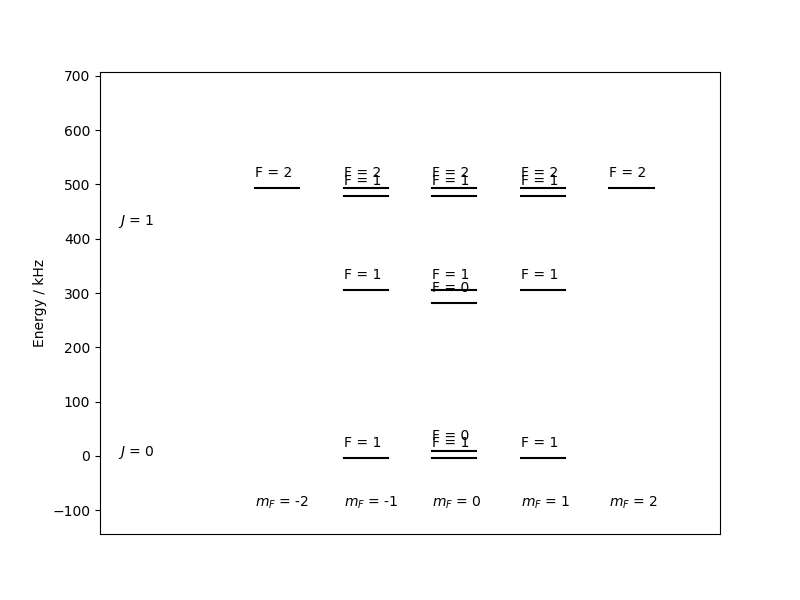

In [153]:
#Find the energy scale of the energy differences
energy_scale = np.max(ground_state_energies)-np.min(ground_state_energies)

#Define the y-axis separation for electronic states and different rotational states (not drawing to scale)
es_scale = 10 * energy_scale
J_scale = 2 * energy_scale 

#Separation for different mF levels along x
mF_x = 2

#Width of mF levels along x
mF_w = 1

#Initialize figure
fig, ax = plt.subplots(figsize = (8,6))

#Hide x-axis
ax.get_xaxis().set_visible(False)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

#Loop over states, find energy and draw a line at the correct position
for i, state in enumerate(ground_state_list):
    energy = ground_state_energies[i]
    electronic_state = state.electronic_state
    F = state.F
    mF = state.mF
    J = state.J
    
    y_coordinate = energy + J*J_scale + electronic_state*es_scale
    x_coordinate = mF_x*mF
    
    ax.plot([x_coordinate-mF_w/2, x_coordinate+mF_w/2], [y_coordinate,y_coordinate],'black')
    ax.text(x_coordinate-mF_w/2, y_coordinate+20, "F = {:.3s}".format(str(F),str(mF)), fontdict=font)
    
#Set axis labels etc
ax.set_ylabel('Energy / kHz')

ax.set_xlim(-(Fmax+2)*mF_x,(Fmax+1)*mF_x)
ax.set_ylim(np.min(ground_state_energies)-0*energy_scale,np.max(ground_state_energies)+3*energy_scale)

for mF in np.arange(-Fmax,Fmax+1,1):
    x_coordinate = mF_x*mF
    y_coordinate = np.min(ground_state_energies)+50
    ax.text(x_coordinate-mF_w/2, y_coordinate, "$m_F$ = {:.3s}".format(str(mF)), fontdict=font)

for J in J_list_gs:
    x_coordinate = -mF_x*(Fmax+1.8)
    y_coordinate = J*J_scale
    ax.text(x_coordinate, y_coordinate, "$J$ = {:.3s}".format(str(J)), fontdict=font)
